# Notebook for retrieving paper statistics

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import plotly.express as px

In [2]:
data = pd.read_csv("data/dataset.csv", index_col=0)
data.sample(3)

,S&P500,CAC40
Date,,
2021-11-25,NaN,0.004777
2011-09-01,-0.011871,0.002785
2021-02-25,-0.024479,-0.002430


In [3]:
df_trv = data.rolling(5).std()
df_trv.index = pd.to_datetime(df_trv.index)
df_trv = df_trv.iloc[4:]
df_trv.sample(3)

,S&P500,CAC40
Date,,
2016-09-01,0.003130,0.005992
2012-08-06,0.010517,0.026159
2019-05-16,0.013897,0.010926


## The data set is the S&P 500

In [4]:
df = df_trv["S&P500"].dropna()  # Don't forget to drop NaN values
df.sample(3)

Date
2018-02-08    0.024205
2001-07-18    0.013588
2002-04-15    0.013748
Name: S&P500, dtype: float64

# Table 1

In [5]:
df_agg = df.groupby(df.index.to_period("Y")).agg(['mean', 'std', 'skew', lambda x : pd.DataFrame.kurt(x)+3]).set_axis(["Mean", "STD", "Skewness", "Kurtosis"], axis = 1)
df_agg.loc[["2008", "2009", "2010", "2017", "2018"]].round(3)

,Mean,STD,Skewness,Kurtosis
Date,,,,
2008,0.022,0.016,1.515,4.691
2009,0.015,0.008,0.904,3.452
2010,0.010,0.006,0.982,4.187
2017,0.004,0.002,0.984,3.373
2018,0.009,0.006,1.455,4.824


### Scaled to the range [0, 1]

In [6]:
mi = df.min()
ma = df.max()
df = (df - mi)/(ma-mi)

In [7]:
data1 = []
data2 = []

columns=[
        "Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
        "Critical Value (1%)",
        "Critical Value (5%)",
    ]

periods = ["2000:2007", "2000:2008", "2000:2009", "2009:2016", "2010:2017"]
for period in periods:
    borne = period.split(":")
    
    df_aux = df[borne[0]:borne[1]]
    pivot_index_training_1 = round(df_aux.shape[0] * 0.25)
    pivot_index_training_2 = round(df_aux.shape[0] * 0.75)

    df_train_1 = df_aux.iloc[:pivot_index_training_1]
    df_train_2 = df_aux.iloc[pivot_index_training_1:pivot_index_training_2]

    df_test=adfuller(df_train_1)
    aux = df_test[4]
    df_test = list(df_test[:4])
    df_test.append(aux["1%"])
    df_test.append(aux["5%"])
    data1.append(df_test)
    df_test=adfuller(df_train_2)
    aux = df_test[4]
    df_test = list(df_test[:4])
    df_test.append(aux["1%"])
    df_test.append(aux["5%"])
    data2.append(df_test)

# Table 2

### Data for training 1st level

In [8]:
pd.DataFrame(data1, index=periods, columns=columns)

,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%)
2000:2007,-4.567741,0.000148,11,423,-3.445904,-2.868397
2000:2008,-4.872523,0.000039,11,479,-3.444076,-2.867593
2000:2009,-5.020157,0.000020,9,536,-3.442609,-2.866947
2009:2016,-2.429764,0.133511,6,435,-3.445473,-2.868207
2010:2017,-3.030622,0.032132,12,428,-3.445721,-2.868317


### Data for training 2nd level

In [9]:
pd.DataFrame(data2, index=periods, columns=columns)

,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%)
2000:2007,-3.366176,1.216741e-02,12,857,-3.438003,-2.864918
2000:2008,-3.152644,2.289476e-02,17,963,-3.437159,-2.864546
2000:2009,-4.562501,1.513649e-04,20,1072,-3.436465,-2.864240
2009:2016,-5.103244,1.380993e-05,6,878,-3.437820,-2.864837
2010:2017,-7.870873,4.989223e-12,5,875,-3.437846,-2.864849


In [10]:
from classes.Ann import Ann
from classes.DataLoader import DataLoader
from classes.DataLoader_batch import DataLoader_batch
from classes.Simulation import Simulation

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np

from utils.init_functions import random_normal
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

index = "S&P500"
data = pd.read_csv("data/dataset.csv", index_col=0)
data.index = pd.to_datetime(data.index)
df_trv = data.rolling(5).std()
df_trv.index = pd.to_datetime(df_trv.index)
df_trv = df_trv.iloc[4:]
dfe = df_trv[index].dropna() 
mi = dfe.min()
ma = dfe.max()
dfe = (dfe - mi)/(ma-mi)
dfe_r = data["S&P500"][dfe.index]

am = arch_model(dfe_r.values, p=1, q=1)
res = am.fit(disp='off')
dfe_garch = pd.Series(res.conditional_volatility, index=dfe_r.index)
mi_garch = dfe_garch.min()
ma_garch = dfe_garch.max()
dfe_garch = (dfe_garch - mi_garch)/(ma_garch-mi_garch)

am = arch_model(dfe_r.values, vol='EGARCH' , p = 1 , o = 0 , q = 1)
res = am.fit(disp='off')
dfe_egarch = pd.Series(res.conditional_volatility, index=dfe_r.index)
mi_egarch = dfe_egarch.min()
ma_egarch = dfe_egarch.max()
df_egarch = (dfe_egarch - mi_egarch)/(ma_egarch-mi_egarch)

periods = {
    "2000-2007":"2008",
    "2001-2008":"2009",
    "2002-2009":"2010",
    "2009-2016":"2017",
    "2010-2017":"2018",
}

params_stacked = {
    "2000-2007":[0.0033,0],
    "2001-2008":[0.0059, 0.01],
    "2002-2009":[0.0136, 0],
    "2009-2016":[0.085, 0.02],
    "2010-2017":[0.01, 0.011],
}

params_ml = {
    "2000-2007":[10, 24, 1479, 0.003, 0.0001, 0.45],
    "2001-2008":[10, 107, 3000, 0.001, 0.0001, 0.55],
    "2002-2009":[1, 37, 3583, 0.001, 0.0004, 0.17],
    "2009-2016":[30, 118, 1000, 0.009, 0.0002, 0.13],
    "2010-2017":[7, 175, 1000, 0.003, 0.0001, 0.54],
}

c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Stacked Ann

In [11]:
pred_stacked = []
res_stacked = []
rmse_stacked = []
date_index = []

for period in periods:

    df = dfe[period[:4]:period[5:]]

    pivot_index_training_1 = round(df.shape[0] * 0.25)
    pivot_index_training_2 = round(df.shape[0] * 0.75)

    df_train_1 = df.iloc[:pivot_index_training_1]
    df_ann = df.iloc[pivot_index_training_1:]

    ite_train_1 = DataLoader(df=df_train_1, Y=df_train_1.values, window_size=30, batch_size=df_train_1.shape[0])
    for batch in ite_train_1: # Only one batch there
        X_train_1,y_train_1 = batch

    rf_rgs = RandomForestRegressor(n_estimators=params_ml[period][0], max_depth=params_ml[period][1])  # RandomForestRegressor(max_features = 10, min_samples_split = 24)   
    rf_rgs.fit(X_train_1,y_train_1)

    sv_rgs = SVR(kernel='rbf', gamma=params_ml[period][4], epsilon=params_ml[period][5])
    sv_rgs.fit(X_train_1,y_train_1)

    gb_rgs = GradientBoostingRegressor(learning_rate=params_ml[period][3], n_estimators=params_ml[period][2])  # GradientBoostingRegressor(learning_rate = 0.003, n_estimators=1479)
    gb_rgs.fit(X_train_1,y_train_1)

    ite = DataLoader(df=df_ann, Y=df_ann.values, window_size=30, batch_size=df_ann.shape[0])
    for batch in ite: # Only one batch there
        X,y = batch

    df_train_ann = pd.DataFrame(X, index=df_ann.index[30:])
    df_train_ann["rf"] = rf_rgs.predict(X)
    df_train_ann["sv"] = sv_rgs.predict(X)
    df_train_ann["gb"] = gb_rgs.predict(X)

    kwargs = dict(
        learning_rate = params_stacked[period][0],
        period = period,
        batch_size = df_train_ann.shape[0],
        num_epochs = 10000, 
        window_size = 30,
        weight_decay = 0,
        tab = df_train_ann.values,
        path="models/torch/stacked_ann/{}".format(period),
        #l2_lambda = params_stacked[period][1],
        y = y,
    )

    sim = Simulation(**kwargs)

    df_comparaison = dfe[periods[period]]
    date_index.append(df_comparaison.index)
    ite_comp = DataLoader(df=df_comparaison, Y=df_comparaison.values, window_size=30, batch_size=df_comparaison.shape[0])
    for batch in ite_comp: # Only one batch there
        X_comp,y_comp = batch
        
    df_rep = pd.DataFrame(X_comp, index=df_comparaison.index[30:])
    df_rep["rf"] = rf_rgs.predict(X_comp)
    df_rep["sv"] = sv_rgs.predict(X_comp)
    df_rep["gb"] = gb_rgs.predict(X_comp)

    ite_comp_ann = DataLoader_batch(tab=df_rep.values, Y=y_comp, batch_size=df_rep.shape[0])
    for batch in ite_comp_ann: # Only one batch there
        X,y = batch
    pred_stacked.append(sim.Ann(X).detach().numpy())
    res_stacked.append(y.numpy())
    rmse_stacked.append(mean_squared_error(
        pred_stacked[-1], res_stacked[-1],  squared=False
        )
    )

### Feed forward Ann

In [12]:
pred_feed = []
res_feed = []
rmse_feed = []

for period in periods:

    df = dfe[period[:4]:period[5:]]

    pivot_index_training_1 = round(df.shape[0] * 0.25)
    pivot_index_training_2 = round(df.shape[0] * 0.75)

    df_ann = df.iloc[pivot_index_training_1:]

    ite = DataLoader(df=df_ann, Y=df_ann.values, window_size=30, batch_size=df_ann.shape[0])
    for batch in ite: # Only one batch there
        X,y = batch

    kwargs = dict(
        learning_rate = params_stacked[period][0],
        period = period,
        batch_size = df_train_ann.shape[0],
        num_epochs = 10000, 
        window_size = 30,
        weight_decay = 0,
        tab = df_train_ann.values,
        path="models/torch/feed_forward_ann/{}".format(period),
        #l2_lambda = params_stacked[period][1],
        y = y,
    )

    sim = Simulation(**kwargs)

    df_comparaison = dfe[periods[period]]
    ite_comp = DataLoader(df=df_comparaison, Y=df_comparaison.values, window_size=30, batch_size=df_comparaison.shape[0])
    for batch in ite_comp: # Only one batch there
        X_comp,y_comp = batch
        
    ite_comp_ann = DataLoader_batch(tab=X_comp, Y=y_comp, batch_size=len(X_comp))
    for batch in ite_comp_ann: # Only one batch there
        X,y = batch
        
    pred_feed.append(sim.Ann(X).detach().numpy())
    res_feed.append(y.numpy())
    rmse_feed.append(mean_squared_error(
        pred_feed[-1], res_feed[-1],  squared=False
        )
    )

In [13]:
pred_garch = []
res_garch = []
rmse_garch = []
for period in periods:

    df = dfe[periods[period]]
    df_garch = dfe_garch[periods[period]]

    df_ann = df
    df_ann_garch = df_garch

    ite = DataLoader(df=df_ann, Y=df_ann.values, window_size=30, batch_size=df_ann.shape[0])
    for batch in ite: # Only one batch there
        X,y = batch

    ite_garch = DataLoader(df=df_ann_garch, Y=df_ann_garch.values, window_size=30, batch_size=df_ann_garch.shape[0])
    for batch in ite_garch: # Only one batch there
        X_garch,y_garch = batch

    kwargs = dict(
        learning_rate = params_stacked[period][0],
        period = period,
        batch_size = len(X_garch),
        num_epochs = 10000, 
        window_size = 30,
        weight_decay = 0,
        #l2_lambda = params_stacked[period][1],
        path="models/torch/ann_garch/{}".format(period),
        tab = X_garch,
        y = y,
    )

    sim = Simulation(**kwargs)

    ite_comp_ann = DataLoader_batch(tab=X_garch, Y=y, batch_size=len(X_garch))
    for batch in ite_comp_ann: # Only one batch there
        X_garch,y = batch

    pred_garch.append(sim.Ann(X_garch).detach().numpy())
    res_garch.append(y.numpy())
    rmse_garch.append(mean_squared_error(
        pred_garch[-1], res_garch[-1],  squared=False
        )
    )

In [14]:
pred_egarch = []
res_egarch = []
rmse_egarch = []
for period in periods:

    df = dfe[periods[period]]
    df_egarch = dfe_egarch[periods[period]]

    df_ann = df
    df_ann_egarch = df_egarch

    ite = DataLoader(df=df_ann, Y=df_ann.values, window_size=30, batch_size=df_ann.shape[0])
    for batch in ite: # Only one batch there
        X,y = batch

    ite_egarch = DataLoader(df=df_ann_egarch, Y=df_ann_egarch.values, window_size=30, batch_size=df_ann_egarch.shape[0])
    for batch in ite_egarch: # Only one batch there
        X_egarch,y_egarch = batch

    kwargs = dict(
        learning_rate = params_stacked[period][0],
        period = period,
        batch_size = len(X_egarch),
        num_epochs = 10000, 
        window_size = 30,
        weight_decay = 0,
        #l2_lambda = params_stacked[period][1],
        path="models/torch/ann_egarch/{}".format(period),
        tab = X_egarch,
        y = y,
    )

    sim = Simulation(**kwargs)

    ite_comp_ann = DataLoader_batch(tab=X_egarch, Y=y, batch_size=len(X_egarch))
    for batch in ite_comp_ann: # Only one batch there
        X_egarch,y = batch

    pred_egarch.append(sim.Ann(X_egarch).detach().numpy())
    res_egarch.append(y.numpy())
    rmse_egarch.append(mean_squared_error(
        pred_egarch[-1], res_egarch[-1],  squared=False
        )
    )

# Table 6

In [15]:
df_rmse = pd.DataFrame(
    data=[rmse_stacked, rmse_egarch, rmse_garch, rmse_feed],
    columns = [["RMSE:2008", "RMSE:2009", "RMSE:2010", "RMSE:2017", "RMSE:2018"]],
    index=["Stacked-Ann", "ANN-EGARCH", "ANN-GARCH", "ANN"]
    )
df_rmse.to_excel("output/rmse_s&p.xlsx")
df_rmse

,RMSE:2008,RMSE:2009,RMSE:2010,RMSE:2017,RMSE:2018
Stacked-Ann,0.109433,0.048692,0.041945,0.018985,0.037620
ANN-EGARCH,0.087439,0.042227,0.035918,0.031502,0.031903
ANN-GARCH,0.112480,0.049948,0.044374,0.039578,0.041781
ANN,0.126145,0.054242,0.044093,0.019929,0.033864


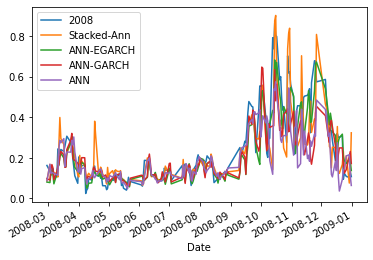

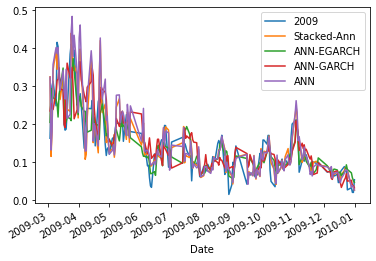

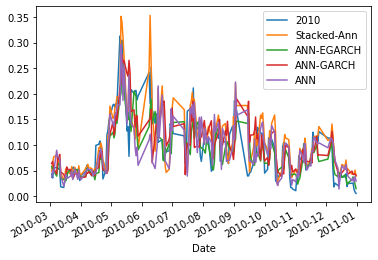

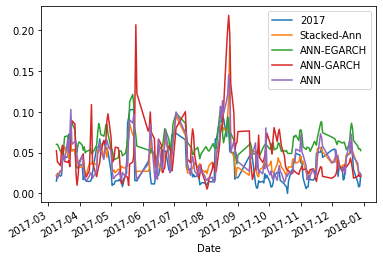

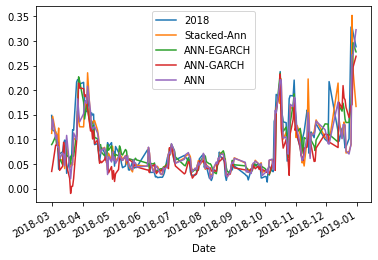

In [16]:
dico = {"2008":0, "2009":1, "2010":2, "2017":3, "2018":4}
dico_bis = {'Stacked-Ann':pred_stacked, 'ANN-EGARCH':pred_egarch, 'ANN-GARCH':pred_garch, 'ANN':pred_feed}
for date in dico:
    df = pd.DataFrame(res_stacked[dico[date]], columns=[date], index=date_index[dico[date]][30:])
    for col in dico_bis:
        df[col] = dico_bis[col][dico[date]]
    df.to_excel("output/{}_prediction.xlsx".format(date))
    df.plot()
    fig = px.line(df)
    fig.write_html("fig/{}_predictions.html".format(date))